# Cs/Th analysis

In [140]:
%matplotlib inline

import os
import textwrap
import math

import datetime as dt
import pandas as pd

import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

import numpy             as np
import tables            as tb

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.reco.tbl_functions  as tbl
import invisible_cities.sierpe.blr          as blr

from   invisible_cities.icaro. hst_functions   import display_matrix
from   invisible_cities.database               import load_db

from   matplotlib                              import gridspec
from   matplotlib.patches                      import Ellipse
from   scipy.optimize                          import curve_fit
from   scipy.interpolate                       import interp1d

from   matplotlib.colors                       import SymLogNorm

# Formatting options
mpl.rcParams.update({'font.size': 14})
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['patch.force_edgecolor'] = False
mpl.rcParams['patch.facecolor'] = 'gray'
hargs = {'histtype': 'stepfilled', 'edgecolor': 'black', 'facecolor': 'gray'}

# Directory to which figures will be stored
save_dir = "fig_10bar_paper"
ftype = "pdf"

E_0vbb = 2458 # keV

## Function definitions

In [53]:
# Fit to 2 Gaussians
def gauss2(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    if sigma1 <= 0. or sigma2 <= 0:
        return np.inf
    return amp1/(2*np.pi)**.5/sigma1 * np.exp(-0.5*(x-mu1)**2./sigma1**2.) + amp2/(2*np.pi)**.5/sigma2 * np.exp(-0.5*(x-mu2)**2./sigma2**2.)

# Fit to Gaussian + exponential
def gaussexpo(x, amp, mu, sigma, const, mean, x0):

    if sigma <= 0.:
        return np.inf
    
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)

# (code from Gonzalo)
# Return resolution extrapolated to Qbb
def reso(values,epeak):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (epeak/2458)**0.5

# Return errors on resolution extrapolated to Qbb
def reso_errors(values,errors,epeak):
    _, mu, sigma = values
    _, err_mu, err_sigma = errors
    r = 235. * sigma/mu
    err_r = r*np.sqrt((err_sigma/sigma)**2 + (err_mu/mu)**2)
    return err_r, err_r * (epeak/E_0vbb)**0.5

# Returns text output for Gaussian fit function
def gausstext(values,epeak):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3f}%
        R$_\\beta$$_\\beta$ = {:.3f}%""".format(*values[1:], *reso(values,epeak)))
        #$\chi^2$ = {:.2f}""".format(*values[1:], *reso(values,epeak),chi2))

# Returns text output for Gaussian + exponential fit function
def gaussexpotext(values,epeak):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3f}%
        R$_\\beta$$_\\beta$ = {:.3f}%""".format(*values[1:3], *reso(values[0:3],epeak)))

# Returns text output for two-Gaussian fit function
def gauss2text(values,epeak1,epeak2):
    return textwrap.dedent("""
        $\mu_1$ = {:.1f}
        $\sigma_1$ = {:.2f}
        R$_1$ = {:.3f}%
        R$_1$$_\\beta$$_\\beta$ = {:.3f}%
        $\mu_2$ = {:.1f}
        $\sigma_2$ = {:.2f}
        R$_2$ = {:.3f}%
        R$_2$$_\\beta$$_\\beta$ = {:.3f}%""".format(*values[1:3], *reso(values[0:3],epeak1), *values[4:], *reso(values[3:],epeak2)))

# Modified hst_functions.display_matrix
def display_matrix_mod(x, y, z, mask=None, **kwargs):
    """
    Display the matrix z using the coordinates x and y as the bin centers.
    """
    nx = np.size(x)
    ny = np.size(y)

    dx = (np.max(x) - np.min(x)) / nx
    dy = (np.max(y) - np.min(y)) / ny

    x_binning = np.linspace(np.min(x) - dx, np.max(x) + dx, nx + 1)
    y_binning = np.linspace(np.min(y) - dy, np.max(y) + dy, ny + 1)

    x_ = np.repeat(x, ny)
    y_ = np.tile  (y, nx)
    z_ = z.flatten()

    if mask is None:
        mask = np.ones_like(z_, dtype=bool)
        
    h, x, y = np.histogram2d(-y_[mask], x_[mask], bins=[x_binning, y_binning], weights=z_[mask], **kwargs)
    return h, x, y

# A linear function mx + b
def flinear(x, m, b):
    return m*x + b

# A quadratic function mx**2 + b
def fquadratic(x, m, b):
    return m*x**2 + b

# A sqrt function a*sqrt(x)
def fsqrt(x, a, b):
    return a*x**0.5 + b

# A 2nd order polynomial
def poly2(x, a, b, c):
    return a*x**2 + b*x + c

# A 4th-order polynomial
def poly4(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

# A 2D Gaussian
def mult_gaussFun_Fit(x_y,*m):
    (x,y) = x_y
    A,x0,y0,varx,vary,rho = m
    #print("x0 is {}".format(x0))
    X,Y = np.meshgrid(x,y)
    assert rho != 1
    a = 1/(2*(1-rho**2))
    Z = A*np.exp(-a*((X-x0)**2/(varx)+(Y-y0)**2/(vary)-(2*rho/(np.sqrt(varx*vary)))*(X-x0)*(Y-y0)))
    return Z.ravel()

# Fit function for energy resolution.
def fres(x, a, b):
    return a + b/x**0.5

-------------------------

# Save/load main event quantities

In [83]:
# Overall energy calibration, runs 6342 - 6485: NO Z-CORRECTION
# Fit parameters are: a = -4.701249546416281e-11, b = 0.003176590288877461, c = 0.9038455914669522
# Residuals (%): [-0.19751414  0.23888281 -0.2239364   0.24644533]
    
# Overall energy calibration, runs 6342 - 6485: Z-CORRECTION 2.84e-4
# Fit parameters are: a = -1.3768135826402437e-10, b = 0.003178431071354174, c = 0.8730450927434624
# Residuals (%): [-0.12483841  0.14936392 -0.13733389  0.14729371]

CAL_a = -1.3768135826402437e-10
CAL_b = 0.003178431071354174
CAL_c = 0.8730450927434624

def StoE(spes, fscale=1):
    if(fscale >= 1):
        return CAL_a*spes**2 + CAL_b*spes + CAL_c
    elif(fscale < 0): # set fscale to -1 to do nothing
        return -fscale*spes
    else:
        return fscale*spes

# All runs
evtfnames   = ["/Users/jrenner/local/data/NEW/6342/15x15x15/npz_combined_6342.npz",
               "/Users/jrenner/local/data/NEW/6346/15x15x15/npz_combined_6346.npz",
               "/Users/jrenner/local/data/NEW/6347/15x15x15/npz_combined_6347.npz",
               "/Users/jrenner/local/data/NEW/6348/15x15x15/npz_combined_6348.npz",
               "/Users/jrenner/local/data/NEW/6349/15x15x15/npz_combined_6349.npz",
               "/Users/jrenner/local/data/NEW/6351/15x15x15/npz_combined_6351.npz",
               "/Users/jrenner/local/data/NEW/6352/15x15x15/npz_combined_6352.npz",
               "/Users/jrenner/local/data/NEW/6365/15x15x15/npz_combined_6365.npz",
               "/Users/jrenner/local/data/NEW/6482/15x15x15/npz_combined_6482.npz", 
               "/Users/jrenner/local/data/NEW/6483/15x15x15/npz_combined_6483.npz",
               "/Users/jrenner/local/data/NEW/6484/15x15x15/npz_combined_6484.npz",
               "/Users/jrenner/local/data/NEW/6485/15x15x15/npz_combined_6485.npz"]

kalpha_mu = [9073.87757,  # 6342
             9013.27925,  # 6346
             8991.11666,  # 6347
             8964.70222,  # 6348
             9002.96242,  # 6349
             8981.19232,  # 6351
             8997.61118,  # 6352
             9123.09052,  # 6365
             9461.06544,  # 6482
             9454.31340,  # 6483
             9457.98010,  # 6484
             9472.07755]  # 6485

## Load the information directly from files

`A_evtnum`      -- event number<br>
`A_time`        -- timestamp<br>
`A_eblob1`      -- energy of blob1 (most energetic) as obtained from Paolina analysis<br>
`A_eblob2`      -- energy of blob2 (least energetic) as obtained from Paolina analysis<br>
`A_emtrk`       -- energy of 10 most energetic Paolina tracks in the event<br>
`A_xmtrk`       -- average reconstructed $x$-coordinate of 10 most energetic Paolina tracks in the event<br>
`A_ymtrk`       -- average reconstructed $y$-coordinate of 10 most energetic Paolina tracks in the event<br>
`A_zmtrk`       -- average reconstructed $z$-coordinate of 10 most energetic Paolina tracks in the event<br>
`A_ntrks`       -- number of tracks in the event<br>
`A_lmtrk`       -- length of most energetic Paolina track in event<br>
`A_nvox`        -- number of voxels in the event<br>
`A_nhits`       -- number of hits in the event<br>
`A_Ec`          -- fully corrected energy (lifetime by hit + $(x,y)$ by hit)<br>
`A_Eczlen`      -- fully corrected energy + z-length correction<br>
`A_E0`          -- uncorrected energy<br>
`A_xavg`        -- average reconstructed $x$-coordinate of event<br>
`A_yavg`        -- average reconstructed $y$-coordinate of event<br>
`A_zavg`        -- average reconstructed $z$-coordinate of event<br>
`A_ravg`        -- average $r = \sqrt{x^2 + y^2}$ of event<br>
`A_xmin`        -- minimum reconstructed $x$-coordinate of event<br>
`A_ymin`        -- minimum reconstructed $y$-coordinate of event<br>
`A_zmin`        -- minimum reconstructed $z$-coordinate of event<br>
`A_xmax`        -- maximum reconstructed $x$-coordinate of event<br>
`A_ymax`        -- maximum reconstructed $y$-coordinate of event<br>
`A_zmax`        -- maximum reconstructed $z$-coordinate of event<br>
`A_rmin`        -- minimum value of $r = \sqrt{x^2 + y^2}$ over all hits in event<br>
`A_rmax`        -- maximum value of $r = \sqrt{x^2 + y^2}$ over all hits in event<br>

In [84]:
A_evtnum = []; A_time = []; A_ES1 = []
A_eblob1 = []; A_eblob2 = []; A_emtrk = []; A_etrks = []; A_xtrks = []; A_ytrks = []; A_ztrks = []
A_ntrks = []; A_lmtrk = []; A_nvox = []; A_nhits = []
A_Ec = []; A_Eczlen = []; A_E0 = []; A_Echead = []; A_Ectail = []
A_xavg = []; A_yavg = []; A_zavg = []; A_ravg = []
A_xmin = []; A_ymin = []; A_zmin = []
A_xmax = []; A_ymax = []; A_zmax = []
A_rmin = []; A_rmax = []
for ii,fname in enumerate(evtfnames):
 
    fscale = kalpha_mu[0]/kalpha_mu[ii]

    print("Adding file {} with fscale {} ...".format(fname,fscale))

    fn = np.load(fname)
    A_evtnum = np.concatenate((A_evtnum,fn['A_evtnum']))
    A_time   = np.concatenate((A_time,fn['A_time']))
    A_ES1    = np.concatenate((A_ES1,fn['A_ES1']))
    A_eblob1 = np.concatenate((A_eblob1,fn['A_eblob1']))
    A_eblob2 = np.concatenate((A_eblob2,fn['A_eblob2']))
    A_ntrks  = np.concatenate((A_ntrks,fn['A_ntrks']))
    A_lmtrk  = np.concatenate((A_lmtrk,fn['A_lmtrk']))
    A_nvox   = np.concatenate((A_nvox,fn['A_nvox']))
    A_nhits  = np.concatenate((A_nhits,fn['A_nhits']))
    A_Ec     = np.concatenate((A_Ec,fscale*fn['A_Ec']))
    A_Eczlen = np.concatenate((A_Eczlen,fscale*fn['A_Eczlen']))
    A_E0     = np.concatenate((A_E0,fscale*fn['A_E0']))
    A_xavg   = np.concatenate((A_xavg,fn['A_xavg']))
    A_yavg   = np.concatenate((A_yavg,fn['A_yavg']))
    A_zavg   = np.concatenate((A_zavg,fn['A_zavg']))
    A_ravg   = np.concatenate((A_ravg,fn['A_ravg']))
    A_xmin   = np.concatenate((A_xmin,fn['A_xmin']))
    A_ymin   = np.concatenate((A_ymin,fn['A_ymin']))
    A_zmin   = np.concatenate((A_zmin,fn['A_zmin']))
    A_xmax   = np.concatenate((A_xmax,fn['A_xmax']))
    A_ymax   = np.concatenate((A_ymax,fn['A_ymax']))
    A_zmax   = np.concatenate((A_zmax,fn['A_zmax']))
    A_rmin   = np.concatenate((A_rmin,fn['A_rmin']))
    A_rmax   = np.concatenate((A_rmax,fn['A_rmax']))
    
    if(len(A_etrks) > 0): A_etrks  = np.concatenate((A_etrks,fscale*fn['A_emtrk']))
    else: A_etrks = fn['A_emtrk']
    
    if(len(A_xtrks) > 0): A_xtrks  = np.concatenate((A_xtrks,fn['A_xmtrk']))
    else: A_xtrks = fn['A_xmtrk']
    
    if(len(A_ytrks) > 0): A_ytrks  = np.concatenate((A_ytrks,fn['A_ymtrk']))
    else: A_ytrks = fn['A_ymtrk']
        
    if(len(A_ztrks) > 0): A_ztrks  = np.concatenate((A_ztrks,fn['A_zmtrk']))
    else: A_ztrks = fn['A_zmtrk']

        
# Calibrate the energy.
A_Ecal = CAL_a*A_Ec**2 + CAL_b*A_Ec + CAL_c
A_etrks = CAL_a*A_etrks**2 + CAL_b*A_etrks + CAL_c

# Produce an array with only the energy of the maximum track for each event.
A_emtrk = np.max(A_etrks,axis=1)
A_emtrk = CAL_a*A_emtrk**2 + CAL_b*A_emtrk + CAL_c

# Correct for z-length effect.
A_zlen = A_zmax - A_zmin
A_Eczlcorr = A_Ecal/(1 - 2.84e-4*A_zlen)

z_corrected = True
if(z_corrected):
    A_Ecplot = A_Eczlcorr
else:
    A_Ecplot = A_Ecal

print("{} total events".format(len(A_evtnum)))

Adding file /Users/jrenner/local/data/NEW/6342/15x15x15/npz_combined_6342.npz with fscale 1.0 ...
Adding file /Users/jrenner/local/data/NEW/6346/15x15x15/npz_combined_6346.npz with fscale 1.0067232267323794 ...
Adding file /Users/jrenner/local/data/NEW/6347/15x15x15/npz_combined_6347.npz with fscale 1.0092047420948491 ...
Adding file /Users/jrenner/local/data/NEW/6348/15x15x15/npz_combined_6348.npz with fscale 1.0121783576655154 ...
Adding file /Users/jrenner/local/data/NEW/6349/15x15x15/npz_combined_6349.npz with fscale 1.00787686837862 ...
Adding file /Users/jrenner/local/data/NEW/6351/15x15x15/npz_combined_6351.npz with fscale 1.010319927098499 ...
Adding file /Users/jrenner/local/data/NEW/6352/15x15x15/npz_combined_6352.npz with fscale 1.0084762931487334 ...
Adding file /Users/jrenner/local/data/NEW/6365/15x15x15/npz_combined_6365.npz with fscale 0.9946056711930993 ...
Adding file /Users/jrenner/local/data/NEW/6482/15x15x15/npz_combined_6482.npz with fscale 0.9590756588192461 ...
A

## Definition of key quantities

In [91]:
# Key variables in constructing cuts.
Emin = StoE(0); Emax = StoE(800000)                  # basic cut energy range
eb1_low = 1260; eb1_high = 1320          # blob plot intervals
eb2_low = 1596; eb2_high = 1645
eb3_low = 1690; eb3_high = 2500
Emin_emtrk = StoE(1000); Emax_emtrk = StoE(2500)     # emtrk basic energy cut range

cwide_zmin = 50; cwide_zmax = 500
cwide_rmax = 180
ctight_zmin = 150; ctight_zmax = 300
ctight_rmax = 150

cs_zmin = cwide_zmin; cs_zmax = cwide_zmax
cs_rmax = cwide_rmax

#cs_zmin = 160; cs_zmax = 300
#cs_rmax = 150

kr_zmin = cwide_zmin; kr_zmax = cwide_zmax
kr_rmax = cwide_rmax

# kr_zmin = 100; kr_zmax = 300
# kr_rmax = 150

xr_zmin = cwide_zmin; xr_zmax = cwide_zmax
xr_rmax = cwide_rmax

#xr_zmin = 100;   xr_zmax = 300
#xr_rmax = 150

th_zmin = cwide_zmin; th_zmax = cwide_zmax
th_rmax = cwide_rmax

#th_zmin = 160; th_zmax = 300
#th_rmax = 150

#tl_zmin = cwide_zmin; tl_zmax = cwide_zmax
#tl_rmax = cwide_rmax

tl_zmin = 160; tl_zmax = 300
tl_rmax = 150

# ------------------------------------------------------------------------------------------
# Pre-defined cuts
C_basic       = (A_E0 > 0) & (A_Ecplot > 0) & (A_zavg < 580)
C_wide        = C_basic & (A_zmin > cwide_zmin) & (A_zmax < cwide_zmax) & (A_rmax < cwide_rmax)
C_tight       = C_basic & (A_zmin > ctight_zmin) & (A_zmax < ctight_zmax) & (A_rmax < ctight_rmax)
C_tfiducial   = (abs(A_xmax) < 100) & (abs(A_ymax) < 100) & (abs(A_xmin) < 100) & (abs(A_ymin) < 100) & (A_zavg > 50) & (A_zavg < 150)

# Cuts defining different spectral regions
C_trks                 = (A_lmtrk > 90) & (A_lmtrk < 180) & (A_ntrks == 1)

C_basic_emtrk          = (A_emtrk > Emin_emtrk) & (A_emtrk < Emax_emtrk)
C_emtrk_regionprepeak  = C_basic_emtrk & (A_emtrk > eb1_low) & (A_emtrk < eb1_high)
C_emtrk_regionpeak     = C_basic_emtrk & (A_emtrk > eb2_low) & (A_emtrk < eb2_high)
C_emtrk_regionpostpeak = C_basic_emtrk & (A_emtrk > eb3_low) & (A_emtrk < eb3_high)

# Extract individual tracks
etrks_basic = A_etrks[C_basic].flatten()
xtrks_basic = A_xtrks[C_basic].flatten()
ytrks_basic = A_ytrks[C_basic].flatten()
ztrks_basic = A_ztrks[C_basic].flatten()
rtrks_basic = np.array([(xx**2 + yy**2)**0.5 for xx,yy in zip(xtrks_basic,ytrks_basic)])

# Peak energies
E_xKalpha = (29.112*0.00261 + 29.461*25.6 + 29.782*47.4)/(0.00261 + 25.6 + 47.4)
E_xKbeta  = (33.562*4.35 + 33.624*8.40 + 33.881*0.085 + 34.419*2.54 + 34.496*0.492)/(4.35 + 8.40 + 0.085 + 2.54 + 0.492)
E_Kr      = 41.543
E_Cs      = 661.657
E_descape = 1592.535
E_Tl      = 2614.533
print("""
E_xKalpha = {}
E_xKbeta = {}
E_Kr = {}
E_Cs = {}
E_descape = {}
E_Tl = {}
""".format(E_xKalpha,E_xKbeta,E_Kr,E_Cs,E_descape,E_Tl))

# S1-S2 cuts
mS1 = 3.6
bS1 = 50
bminusS1 = -50
bplusS1 = 150
#C_S1S2 = ((A_Ec*CAL_m + CAL_b) < (mS1*A_ES1 + bplusS1)) & ((A_Ec*CAL_m + CAL_b) > (mS1*A_ES1 + bminusS1))

print("Events in key quantities: {0}".format(len(A_eblob1)))


E_xKalpha = 29.669410207662434
E_xKbeta = 33.76268210751875
E_Kr = 41.543
E_Cs = 661.657
E_descape = 1592.535
E_Tl = 2614.533

Events in key quantities: 3730961


--------------------------

# Energy resolution analysis

## Energy spectrum (full)

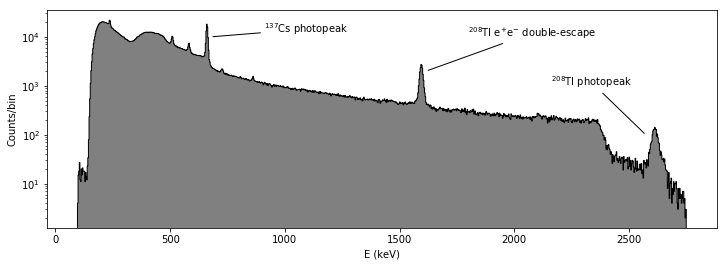

In [86]:
cuts_fullspectrum = C_wide

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

y, x, _ = plt.hist(A_Ecplot[cuts_fullspectrum], 1000, range=[StoE(30000),StoE(9.0e5)], **hargs)
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
plt.yscale('log')
plt.annotate('$^{137}$Cs photopeak', xy=(StoE(215000), 10000),  xycoords='data',
                 xytext=(StoE(290000), 12000), textcoords='data',
                 arrowprops=dict(arrowstyle="-"))
plt.annotate('$^{208}$Tl e$^{+}$e$^{-}$ double-escape', xy=(StoE(520000), 2000),  xycoords='data',
                 xytext=(StoE(580000), 10000), textcoords='data',
                 arrowprops=dict(arrowstyle="-"))
plt.annotate('$^{208}$Tl photopeak', xy=(StoE(840000), 100),  xycoords='data',
                xytext=(StoE(700000), 1000), textcoords='data',
                arrowprops=dict(arrowstyle="-"))

plt.savefig("{}/CSTH_espectrum_full.{}".format(save_dir,ftype), bbox_inches='tight')


## Energy vs. z-length

In [7]:
# Plot the energy vs. z-length.
def plot_E_vs_zlength(L_zlen, L_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, nbins_E, nbins_z, mbound, b0, b1, plt_corrected = False):
    
    # Construct the cuts including the range in (z,E) space to be examined.
    cuts_bounds = (L_Ecplot > L_zlen*mbound + b0) & (L_Ecplot < L_zlen*mbound + b1)
    cuts_range = cuts_base & (L_zlen > plt_rng_zlow) & (L_zlen < plt_rng_zhigh) & (L_Ecplot > plt_rng_Elow) & (L_Ecplot < plt_rng_Ehigh)
    cuts_all = cuts_range & cuts_bounds
    
    # Assume an approximate 1% FWHM sigma on the energy measurements.
    esigma = 1.0*np.mean(L_Ecplot[cuts_all])/235
    
    # Perform the linear fit and extract the parameters.
    p_fit, V_fit = curve_fit(flinear, L_zlen[cuts_all], L_Ecplot[cuts_all], sigma=np.ones(len(L_zlen[cuts_all]))*esigma)
    m = p_fit[0]
    b = p_fit[1]
    var_m = V_fit[0][0]
    var_b = V_fit[1][1]
    var_mb = V_fit[0][1]
    xfit = np.arange(plt_rng_zlow, plt_rng_zhigh, (plt_rng_zhigh-plt_rng_zlow)/100)
    polyfit = np.poly1d([m, b])
    print("Slope for correction {} +/- {}; intercept: {} +/- {}".format(m, var_m**0.5, b, var_b**0.5))
    print("Uncertainty in m/b = {}".format((var_m/b**2 + m**2*var_b/b**4 - m*var_mb/b**3)**0.5))
    
    # Construct the boundary polynomials.
    polyfit_b0 = np.poly1d([mbound, b0])
    polyfit_b1 = np.poly1d([mbound, b1])
    
    # Create the plot.
    fig = plt.figure()
    fig.set_figheight(6.0)
    fig.set_figwidth(16.0)
    
    ax1 = fig.add_subplot(121)
    h, x, y = np.histogram2d(-L_Ecplot[cuts_range], L_zlen[cuts_range], bins=[nbins_E, nbins_z], range=[[-plt_rng_Ehigh,-plt_rng_Elow],[plt_rng_zlow,plt_rng_zhigh]])
    plt.imshow(h, extent=[plt_rng_zlow,plt_rng_zhigh,plt_rng_Elow,plt_rng_Ehigh], interpolation = "none", cmap='jet', aspect=(plt_rng_zhigh-plt_rng_zlow)/(plt_rng_Ehigh-plt_rng_Elow))
    plt.plot(xfit, polyfit_b0(xfit), '--', color='red')
    plt.plot(xfit, polyfit_b1(xfit), '--', color='red')
    plt.plot(xfit, polyfit(xfit), '-', color='red', linewidth=3, label="m/b = {:.2f} $\\times 10^{{-4}}$ mm$^{{-1}}$".format(m/b*1e4))
    plt.legend(loc=1, fontsize=14)
    plt.colorbar()
    #plt.title("Energy vs. z-length")
    plt.ylim([plt_rng_Elow,plt_rng_Ehigh])
    plt.xlim([plt_rng_zlow,plt_rng_zhigh])
    plt.xlabel('z-length (mm)')
    plt.ylabel('E (SPEs)')
    
    if(plt_corrected):
        E_rng = plt_rng_Ehigh - plt_rng_Elow
        ax2 = fig.add_subplot(122)
        h, x, y = np.histogram2d(-L_Ecplot[cuts_range]/(1+(m/b)*L_zlen[cuts_range]), L_zlen[cuts_range], bins=[nbins_E, nbins_z], range=[[-(b+E_rng/2),-(b-E_rng/2)],[plt_rng_zlow,plt_rng_zhigh]])
        plt.imshow(h, extent=[plt_rng_zlow,plt_rng_zhigh,b-E_rng/2,b+E_rng/2], interpolation = "none", cmap='jet', aspect=(plt_rng_zhigh-plt_rng_zlow)/E_rng)
        #plt.plot(xfit, polyfit_b0(xfit), '--', color='red')
        #plt.plot(xfit, polyfit_b1(xfit), '--', color='red')
        #plt.plot(xfit, polyfit(xfit), '-', color='red', linewidth=3, label="m/b = {:.2f} $\\times 10^{{-4}}$ mm$^{{-1}}$".format(m/b*1e4))
        #plt.legend(loc=1, fontsize=14)
        plt.colorbar()
        plt.title("Energy vs. z-length, CORRECTED")
        plt.ylim([b-E_rng/2,b+E_rng/2])
        plt.xlim([plt_rng_zlow,plt_rng_zhigh])
        plt.xlabel('z-length (mm)')
        plt.ylabel('E (SPEs)')

Slope for correction -58.34778933803867 +/- 0.953171080543739; intercept: 209327.95187992658 +/- 19.027900024347865
Uncertainty in m/b = 4.541417301425914e-06


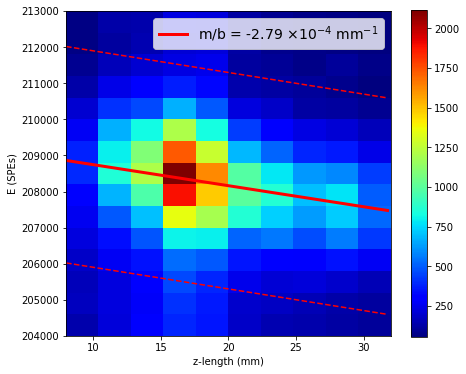

In [8]:
# for Cs peak
mbound = -60
b0 = 206500
b1 = 212500
plt_rng_zlow = 8
plt_rng_zhigh = 32
plt_rng_Elow = StoE(204000)
plt_rng_Ehigh = StoE(213000)

cuts_base = C_wide & (A_ntrks == 1)
plot_E_vs_zlength(A_zlen, A_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 15, 10, mbound, b0, b1)
plt.savefig("{}/CSTH_zwidth_fit_Cs.{}".format(save_dir,'png'), bbox_inches='tight')

Slope for correction -166.10023291677035 +/- 1.9355162355286628; intercept: 513687.28996318404 +/- 90.89320740317545
Uncertainty in m/b = 3.7405948094409767e-06


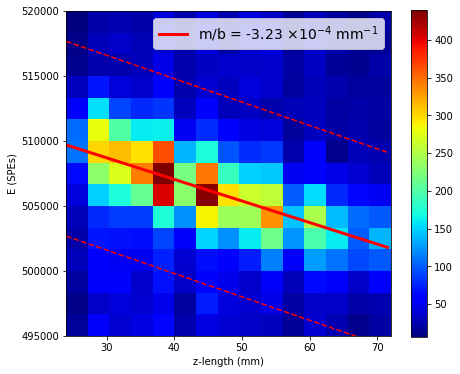

In [9]:
# for double-escape peak
mbound = -180
b0 = 507000
b1 = 522000
plt_rng_zlow = 24
plt_rng_zhigh = 72
plt_rng_Elow = StoE(495000)
plt_rng_Ehigh = StoE(520000)

cuts_base = C_wide & (A_ntrks == 1)
plot_E_vs_zlength(A_zlen, A_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 15, 15, mbound, b0, b1)
plt.savefig("{}/CSTH_zwidth_fit_DE.{}".format(save_dir,'png'), bbox_inches='tight')

Slope for correction -212.38366715857674 +/- 9.42095759100801; intercept: 848531.891483931 +/- 741.9604569696587
Uncertainty in m/b = 1.0998625021951547e-05


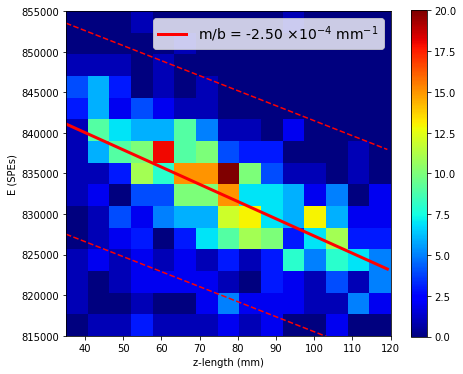

In [15]:
# for Tl peak
mbound = -185
b0 = 834000
b1 = 860000
plt_rng_zlow = 35
plt_rng_zhigh = 120
plt_rng_Elow = StoE(815000)
plt_rng_Ehigh = StoE(855000)

cuts_base = C_wide & (A_ntrks == 1)
plot_E_vs_zlength(A_zlen, A_Ecplot, cuts_base, plt_rng_zlow, plt_rng_zhigh, plt_rng_Elow, plt_rng_Ehigh, 15, 15, mbound, b0, b1)
plt.savefig("{}/CSTH_zwidth_fit_Tl.{}".format(save_dir,'png'), bbox_inches='tight')

# Energy spectrum (Cs 662 keV peak)

Fit parameters are (amp, mu, sigma, A, mean, x0)
[ 4.71940495e+04  6.60708576e+02  3.54967913e+00 -4.06662467e+04
  1.39584208e+02 -1.15317572e-01]
Fit errors are (amp, mu, sigma)
[4.49611599e+02 2.38805355e-02 2.88825824e-02 2.07777240e+04
 6.25865984e+01 4.70941662e-02]
Fit chi2 = 4139.651961630931
Resolution is 1.2625454317232943 +/- 0.010273022142865467
Resolution at Qbb is 0.6550471045217149 +/- 0.005329957433837768


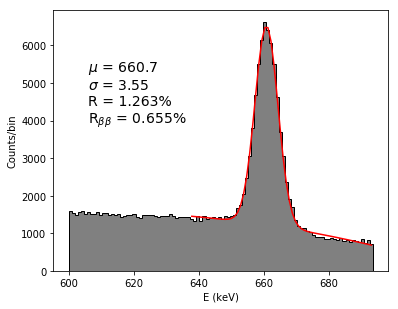

In [87]:
rmax = cs_rmax
zmin = cs_zmin; zmax = cs_zmax
rcuts = C_basic & (A_rmax < rmax) & (A_zmin > zmin) & (A_zmax < zmax) #& (A_ntrks == 1)
fscale = 1 # E_Cs/2.09446644e+05

if(z_corrected):
    plt_rng = [StoE(190000,fscale),StoE(220000,fscale)]
    text_x = 1.01*plt_rng[0]
    nbins = 100
    nxybins = 25

    fit_rng_low = StoE(202000,fscale)
    fit_rng_high = StoE(230900,fscale)
    fit_gauss_A = 120
    fit_gauss_mu = StoE(208600,fscale)
    fit_gauss_sigma = StoE(5000,fscale)
    fit_exp_A = 50
    fit_exp_mean = StoE(3.0e4,fscale)
    fit_exp_x0 = StoE(1.6e5,fscale)
    
else:
    plt_rng = [StoE(190000,fscale),StoE(220000,fscale)]
    text_x = 1.01*plt_rng[0]
    nbins = 120
    nxybins = 25

    fit_rng_low = StoE(202000,fscale)
    fit_rng_high = StoE(230900,fscale)
    fit_gauss_A = 5000
    fit_gauss_mu = StoE(209000,fscale)
    fit_gauss_sigma = StoE(3600,fscale)
    fit_exp_A = 50
    fit_exp_mean = StoE(3.0e4,fscale)
    fit_exp_x0 = StoE(1.6e5,fscale)

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.8)
fig.set_figwidth(6.0)

#ax1 = fig.add_subplot(121)
y0, x0, _ = plt.hist(A_Ecplot[rcuts]*fscale, nbins, range=plt_rng, **hargs)

# Gaussian fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:]), x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, 1, -1/fit_gauss_mu, -1/fit_gauss_mu**2))
#f    = fitf.fit(gaussexpo, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, fit_exp_A, fit_exp_mean, fit_exp_x0))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 3.5*max(y)/6, gausstext(f.values[0:3],E_Cs),fontsize=14)
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
#plt.title("Rmax < {}, {} < Zmax < {}".format(rmax,zmin,zmax), fontsize=12, fontweight='bold')
print("Fit parameters are (amp, mu, sigma, A, mean, x0)")
print(f.values)
print("Fit errors are (amp, mu, sigma)")
print(f.errors)
print("Fit chi2 = {}".format(f.chi2))

# Compute the statistical error.
mu = f.values[1]
sigma = f.values[2]
s_mu = f.errors[1]
s_sigma = f.errors[2]
R = sigma/mu
s_R = (s_sigma**2 + R**2*s_mu**2)**0.5/mu
print("Resolution is {} +/- {}".format(235*R,235*s_R))
print("Resolution at Qbb is {} +/- {}".format(235*R*(E_Cs/E_0vbb)**0.5,235*s_R*(E_Cs/E_0vbb)**0.5))

xyz_rng_low = 645
xyz_rng_high = 675

# ax4 = fig.add_subplot(122) 
# h, x, y = np.histogram2d(-A_yavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], A_xavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
# plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
# plt.colorbar()
# plt.xlabel("average x (mm)")
# plt.ylabel("average y (mm)")
# plt.title("x,y for $E\in ({},{})$".format(xyz_rng_low,xyz_rng_high), fontsize=14)

# Save relevant fit parameters for later use
mu_cs_fid      = f.values[1] 
e_mu_cs_fid    = f.errors[1]
sigma_cs_fid   = f.values[2]
e_sigma_cs_fid = f.errors[2]

plt.savefig("{}/CSTH_espectrum_Cs_fit_zcorrected.{}".format(save_dir,ftype), bbox_inches='tight')

# Energy spectrum (208Tl double-escape peak)

Fit parameters (amp , mu, sigma, A, mean, x0)
[2.04389615e+04 1.59522939e+03 6.97300276e+00 2.47776282e+02
 9.31152389e+02 1.47134445e+03]
Fit errors (amp, mu, sigma, A, mean, x0)
[2.06636904e+02 6.83661990e-02 7.19640647e-02 1.64077441e+08
 2.48962050e+02 6.17006510e+08]
30869
Resolution is 1.0272225799655097 +/- 0.010601422678136333
Resolution at Qbb is 0.8268335890110369 +/- 0.005500341654751656


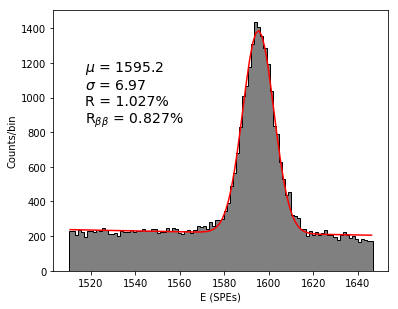

In [88]:
# fit double-escape peak with and without profile corrections
rmax = th_rmax
zmin = th_zmin; zmax = th_zmax
rcuts = C_basic & (A_rmax < rmax) & (A_zmin > zmin) & (A_zmax < zmax) #& (A_ntrks == 1)
fscale = 1 # E_descape/5.13611473e+05

nbins = 100 #80
nxybins = 25

if(z_corrected):
    plt_rng = [StoE(485000,fscale),StoE(530000,fscale)]
    text_x = 1.005*plt_rng[0]

    fit_rng_low = StoE(485000,fscale)
    fit_rng_high = StoE(530000,fscale)
    fit_gauss_A = 1300
    fit_gauss_mu = StoE(515000,fscale)
    fit_gauss_sigma = StoE(7050,fscale)
    fit_exp_A = 80
    fit_exp_mean = StoE(1.16e5,fscale)
    fit_exp_x0 = StoE(2.1e2,fscale)
    
else:
    plt_rng = [StoE(480000,fscale),StoE(525000,fscale)]
    text_x = 1.005*plt_rng[0]

    fit_rng_low = StoE(490000,fscale)
    fit_rng_high = StoE(520000,fscale)
    fit_gauss_A = 80
    fit_gauss_mu = StoE(505000,fscale)
    fit_gauss_sigma = StoE(3050,fscale)
    fit_exp_A = 80
    fit_exp_mean = StoE(1.16e5,fscale)
    fit_exp_x0 = StoE(2.1e2,fscale)

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.8)
fig.set_figwidth(6.0)

y0, x0, _ = plt.hist(A_Ecplot[rcuts]*fscale, nbins, range=plt_rng, **hargs)
#y0, x0, _ = plt.hist(1592*(A_Ec[rcuts]*CAL_m + CAL_b)/prof_D(A_zmax[rcuts] - A_zmin[rcuts]), nbins, range=plt_rng, **hargs)

# Gaussian fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(gaussexpo, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, fit_exp_A, fit_exp_mean, fit_exp_x0))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 3.5*max(y)/6, gaussexpotext(f.values,E_descape), fontsize=14)
plt.xlabel('E (SPEs)')
plt.ylabel('Counts/bin')
#plt.title("Rmax < {}, {} < Zmax < {}".format(rmax,zmin,zmax), fontsize=12, fontweight='bold')
print("Fit parameters (amp , mu, sigma, A, mean, x0)")
print(f.values)
print("Fit errors (amp, mu, sigma, A, mean, x0)")
print(f.errors)
print(len(A_Ecplot[rcuts & (A_Ecplot > 1550) & (A_Ecplot < 1650)]))

# Compute the statistical error.
mu = f.values[1]
sigma = f.values[2]
s_mu = f.errors[1]
s_sigma = f.errors[2]
R = sigma/mu
s_R = (s_sigma**2 + R**2*s_mu**2)**0.5/mu
print("Resolution is {} +/- {}".format(235*R,235*s_R))
print("Resolution at Qbb is {} +/- {}".format(235*R*(E_descape/E_0vbb)**0.5,235*s_R*(E_Cs/E_0vbb)**0.5))

xyz_rng_low = 1575
xyz_rng_high = 1640

# ax4 = fig.add_subplot(122) 
# h, x, y = np.histogram2d(-A_yavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], A_xavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
# plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
# plt.colorbar()
# plt.xlabel("average x (mm)")
# plt.ylabel("average y (mm)")
# plt.title("x,y for $E\in ({},{})$".format(xyz_rng_low,xyz_rng_high), fontsize=14)

# Save relevant fit parameters for later use
mu_de_fid      = f.values[1] 
e_mu_de_fid    = f.errors[1]
sigma_de_fid   = f.values[2]
e_sigma_de_fid = f.errors[2]

plt.savefig("{}/CSTH_espectrum_doubleescape_fit_zcorrected.{}".format(save_dir,ftype), bbox_inches='tight')

# Energy spectrum (208Tl photopeak)

Fit parameters for wide cuts (amp, mu, sigma, A, mean, x0)
[ 3.50956012e+03  2.61286256e+03  1.18373897e+01 -2.91944572e+03
  2.15728239e+00 -3.93415339e-04]
Fit errors for wide cuts (amp, mu, sigma)
[2.60025006e+02 4.49102749e-01 6.10637047e-01 1.32251755e+04
 1.01639427e+01 1.95229279e-03]
Resolution is 1.0646509374978463 +/- 0.054920800244448016
Resolution at Qbb is 1.0980278750613188 +/- 0.028494587421726763


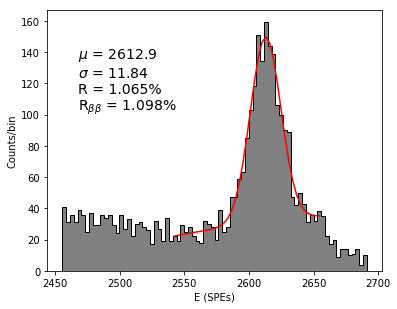

In [89]:
# fit 208Tl photopeak for paper
rmax = tl_rmax
zmin = tl_zmin 
zmax = tl_zmax
rcuts = C_basic & (A_rmax < tl_rmax) & (A_zmin > zmin) & (A_zmax < zmax) #& (A_ntrks == 1)
fscale = 1 # E_Tl/8.50279445e+05

nbins = 80 #40
nxybins = 25

if(z_corrected):
    
    plt_rng = [StoE(800000,fscale),StoE(880000,fscale)]
    text_x = 1.005*plt_rng[0]

    fit_rng_low = StoE(829000,fscale)
    fit_rng_high = StoE(868000,fscale)
    fit_gauss_A = 120
    fit_gauss_mu = StoE(845000,fscale)
    fit_gauss_sigma = StoE(15000,fscale)
    
else:

    plt_rng = [StoE(790000,fscale),StoE(860000,fscale)]
    text_x = 1.005*plt_rng[0]

    fit_rng_low = StoE(800000,fscale)
    fit_rng_high = StoE(860000,fscale)
    fit_gauss_A = 30
    fit_gauss_mu = StoE(830000,fscale)
    fit_gauss_sigma = StoE(20000,fscale)

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.8)
fig.set_figwidth(6.0)

ax1 = fig.add_subplot(111)
y0, x0, _ = plt.hist(A_Ecplot[rcuts]*fscale, nbins, range=plt_rng, **hargs)
#y0, x0, _ = plt.hist(2614*(A_Ec[rcuts]*CAL_m + CAL_b)/prof_Tl(A_zmax[rcuts] - A_zmin[rcuts]), nbins, range=plt_rng, **hargs)

# Gaussian fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:]), x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, 1, -1/fit_gauss_mu, -1/fit_gauss_mu**2))
#f    = fitf.fit(gaussexpo, x, y, (fit_gauss_A, fit_gauss_mu, fit_gauss_sigma, fit_exp_A, fit_exp_mean, fit_exp_x0))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 3.8*max(y)/6, gausstext(f.values[0:3],E_Tl),fontsize=14)
plt.xlabel('E (SPEs)')
plt.ylabel('Counts/bin')
#plt.title("Rmax < {}, {} < Zmax < {}".format(rmax,zmin,zmax), fontsize=12, fontweight='bold')
print("Fit parameters for wide cuts (amp, mu, sigma, A, mean, x0)")
print(f.values)
print("Fit errors for wide cuts (amp, mu, sigma)")
print(f.errors)

# Compute the statistical error.
mu = f.values[1]
sigma = f.values[2]
s_mu = f.errors[1]
s_sigma = f.errors[2]
R = sigma/mu
s_R = (s_sigma**2 + R**2*s_mu**2)**0.5/mu
print("Resolution is {} +/- {}".format(235*R,235*s_R))
print("Resolution at Qbb is {} +/- {}".format(235*R*(E_Tl/E_0vbb)**0.5,235*s_R*(E_Cs/E_0vbb)**0.5))

xyz_rng_low = 2600
xyz_rng_high = 2720

# ax4 = fig.add_subplot(122) 
# h, x, y = np.histogram2d(-A_yavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], A_xavg[rcuts & (A_Ecplot > xyz_rng_low) & (A_Ecplot < xyz_rng_high)], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
# plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
# plt.colorbar()
# plt.xlabel("average x (mm)")
# plt.ylabel("average y (mm)")
# plt.title("x,y for $E\in ({},{})$".format(xyz_rng_low,xyz_rng_high), fontsize=14)

# Save relevant fit parameters for later use
mu_tl_fid      = f.values[1] 
e_mu_tl_fid    = f.errors[1]
sigma_tl_fid   = f.values[2]
e_sigma_tl_fid = f.errors[2]

plt.savefig("{}/CSTH_espectrum_Tl_photopeak_fit_zcorrected.{}".format(save_dir,ftype), bbox_inches='tight')

----

## x-y, and distributions

In [ ]:
cuts_xyz_Cs = C_basic & (A_Ecplot > 645) & (A_Ecplot < 675)

cuts_xyz = cuts_xyz_Cs
nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

# x-y distribution
ax1 = fig.add_subplot(121)
h, x, y = np.histogram2d(-A_yavg[cuts_xyz], A_xavg[cuts_xyz], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")
ctight_circle = plt.Circle((0, 0), cs_rmax, color='gray', alpha=0.15)
ctight_lcircle = plt.Circle((0, 0), cs_rmax, facecolor='none', linestyle='solid', edgecolor='red',linewidth=2)
plt.gca().add_artist(ctight_lcircle)

# z distribution
ax2 = fig.add_subplot(122)
hz = plt.hist(A_zavg[cuts_xyz], bins=nzbins, range=[0,580], **hargs)
plt.xlabel("average z (mm)")
plt.axvline(cs_zmin,linestyle='solid',color='red',linewidth=1.2)
plt.axvline(cs_zmax,linestyle='solid',color='red',linewidth=1.2)
plt.axvspan(cs_zmin,cs_zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.05)

plt.savefig("{}/CSTH_xyzdist_Cs.{}".format(save_dir,ftype), bbox_inches='tight')

In [ ]:
cuts_xyz_Th = C_basic & (A_Ecplot > 1575) & (A_Ecplot < 1615)

cuts_xyz = cuts_xyz_Th
nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

# x-y distribution
ax1 = fig.add_subplot(121)
h, x, y = np.histogram2d(-A_yavg[cuts_xyz], A_xavg[cuts_xyz], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")
ctight_circle = plt.Circle((0, 0), th_rmax, color='gray', alpha=0.15)
ctight_lcircle = plt.Circle((0, 0), th_rmax, facecolor='none', linestyle='solid', edgecolor='red',linewidth=2)
plt.gca().add_artist(ctight_lcircle)

# z distribution
ax2 = fig.add_subplot(122)
hz = plt.hist(A_zavg[cuts_xyz], bins=nzbins, range=[0,580], **hargs)
plt.xlabel("average z (mm)")
plt.axvline(th_zmin,linestyle='solid',color='red',linewidth=1.2)
plt.axvline(th_zmax,linestyle='solid',color='red',linewidth=1.2)
plt.axvspan(th_zmin,th_zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.15)

plt.savefig("{}/CSTH_xyzdist_Th.{}".format(save_dir,ftype), bbox_inches='tight')

In [ ]:
cuts_xyz_xray = (etrks_basic > 27.5) & (etrks_basic < 32)

cuts_xyz = cuts_xyz_xray
nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

# x-y distribution
ax1 = fig.add_subplot(121)
h, x, y = np.histogram2d(-ytrks_basic[cuts_xyz], xtrks_basic[cuts_xyz], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")
ctight_circle = plt.Circle((0, 0), xr_rmax, color='gray', alpha=0.15)
ctight_lcircle = plt.Circle((0, 0), xr_rmax, facecolor='none', linestyle='solid', edgecolor='red',linewidth=2)
plt.gca().add_artist(ctight_lcircle)

# z distribution
ax2 = fig.add_subplot(122)
hz = plt.hist(ztrks_basic[cuts_xyz], bins=nzbins, range=[0,580], **hargs)
plt.xlabel("average z (mm)")
plt.axvline(xr_zmin,linestyle='solid',color='red',linewidth=1.2)
plt.axvline(xr_zmax,linestyle='solid',color='red',linewidth=1.2)
plt.axvspan(xr_zmin,xr_zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.15)

plt.savefig("{}/CSTH_xyzdist_xray.{}".format(save_dir,ftype), bbox_inches='tight')

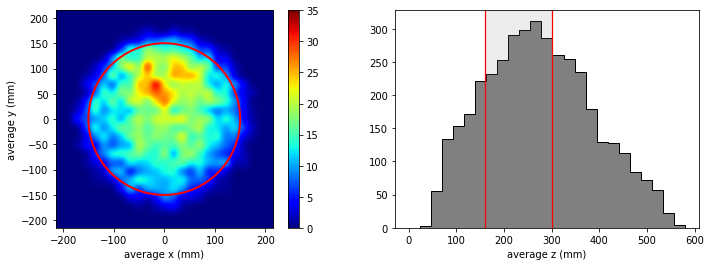

In [93]:
cuts_xyz_tl =  C_basic & (A_Ecplot > 2575) & (A_Ecplot < 2650)

cuts_xyz = cuts_xyz_tl
nxybins = 25
nzbins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

# x-y distribution
ax1 = fig.add_subplot(121)
h, x, y = np.histogram2d(-A_yavg[cuts_xyz], A_xavg[cuts_xyz], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
plt.colorbar()
plt.xlabel("average x (mm)")
plt.ylabel("average y (mm)")
ctight_circle = plt.Circle((0, 0), tl_rmax, color='gray', alpha=0.15)
ctight_lcircle = plt.Circle((0, 0), tl_rmax, facecolor='none', linestyle='solid', edgecolor='red',linewidth=2)
plt.gca().add_artist(ctight_lcircle)

# z distribution
ax2 = fig.add_subplot(122)
hz = plt.hist(A_zavg[cuts_xyz], bins=nzbins, range=[0,580], **hargs)
plt.xlabel("average z (mm)")
plt.axvline(tl_zmin,linestyle='solid',color='red',linewidth=1.2)
plt.axvline(tl_zmax,linestyle='solid',color='red',linewidth=1.2)
plt.axvspan(tl_zmin,tl_zmax,linestyle='solid',facecolor='gray',edgecolor='red',linewidth=1.2,alpha=0.15)

plt.savefig("{}/CSTH_xyzdist_Tl.{}".format(save_dir,ftype), bbox_inches='tight')

## Energy spectrum (x-rays)

Fit parameters for wide cuts (amp, mu, sigma)
[ 2.14924339e+06  9.07515139e+03  2.06172234e+02  9.51548700e+05
  1.03187910e+04  2.29373809e+02 -3.14941675e+03  8.05005140e-01
 -4.34757439e-05]
Fit errors for wide cuts (amp, mu, sigma)
[2.14392857e+04 1.32886436e+00 1.68074251e+00 2.51430567e+04
 3.48305510e+00 4.74006002e+00 6.72805888e+02 1.40135356e-01
 7.10961549e-06]


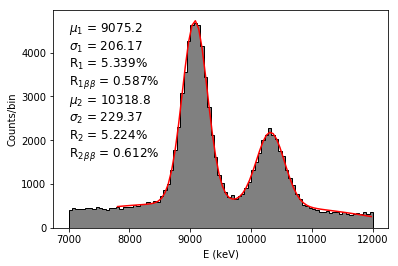

In [79]:
# fit xray peaks with and without profile corrections
rmax = xr_rmax
zmin = xr_zmin; zmax = xr_zmax
xraycuts = (rtrks_basic < rmax) & (ztrks_basic > zmin) & (ztrks_basic < zmax)

plt_rng = [StoE(7000), StoE(12000)]
nbins = 90
nxybins = 25

fig = plt.figure(1)
fig.patch.set_alpha(0.0)
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

fit_rng_low = StoE(7800)
fit_rng_high = StoE(12000)
text_x = StoE(7000)

fit_gauss_A1 = 3000
fit_gauss_mu1 = StoE(9000)
fit_gauss_sigma1 = StoE(300)
fit_gauss_A2 = 1200
fit_gauss_mu2 = StoE(10200)
fit_gauss_sigma2 = StoE(300)

#ax1 = fig.add_subplot(121)
y0, x0, _ = plt.hist(etrks_basic[xraycuts], nbins, range=plt_rng, **hargs)

# 2-Gaussian + polynomial fit
x    = x0[:-1] + np.diff(x0) * 0.5
sel  = coref.in_range(x, fit_rng_low, fit_rng_high)
x, y = x[sel], y0[sel]
f    = fitf.fit(lambda x, *args: gauss2(x, *args[:6]) + fitf.polynom(x, *args[6:]), x, y, (fit_gauss_A1, fit_gauss_mu1, fit_gauss_sigma1, fit_gauss_A2, fit_gauss_mu2, fit_gauss_sigma2, 1., -1./fit_gauss_mu1, -1./fit_gauss_mu1**2))
#f    = fitf.fit(gauss2, x, y, (fit_gauss_A1, fit_gauss_mu1, fit_gauss_sigma1, fit_gauss_A2, fit_gauss_mu2, fit_gauss_sigma2))
plt.plot(x, f.fn(x), "r")
plt.text(text_x, 2.0*max(y)/6, gauss2text(f.values[0:6],E_xKalpha,E_xKbeta), fontsize=12)
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')
#plt.title("Rmax < {}, {} < Zmax < {}".format(rmax,zmin,zmax), fontsize=12, fontweight='bold')
print("Fit parameters for wide cuts (amp, mu, sigma)")
print(f.values)
print("Fit errors for wide cuts (amp, mu, sigma)")
print(f.errors)

xyz_rng_low = 28
xyz_rng_high = 32

# ax4 = fig.add_subplot(122)
# h, x, y = np.histogram2d(-ytrks_basic[xraycuts & (etrks_basic > xyz_rng_low) & (etrks_basic < xyz_rng_high)], xtrks_basic[xraycuts & (etrks_basic > xyz_rng_low) & (etrks_basic < xyz_rng_high)], bins=[nxybins, nxybins], range=[[-215, 215], [-215, 215]])
# plt.imshow(h, extent=[x[0],x[-1],y[0],y[-1]], interpolation = "gaussian", cmap='jet')
# plt.colorbar()
# plt.xlabel("average x (mm)")
# plt.ylabel("average y (mm)")
# plt.title("x,y for $E\in ({},{})$ keV".format(xyz_rng_low,xyz_rng_high), fontsize=14)

# Save relevant fit parameters for later use
mu_xray_fid      = f.values[1] 
e_mu_xray_fid    = f.errors[1]
sigma_xray_fid   = f.values[2]
e_sigma_xray_fid = f.errors[2]

mu_xray2_fid      = f.values[4]
e_mu_xray2_fid    = f.errors[4]
sigma_xray2_fid   = f.values[5]
e_sigma_xray2_fid = f.errors[5]

plt.savefig("{}/CSTH_espectrum_xray_fit.{}".format(save_dir,ftype), bbox_inches='tight')

---

## Energy calibration

** Xenon x-rays** (from [Table of Radioactive Isotopes](http://nucleardata.nuclear.lu.se/toi/xray.asp?act=list&el=Xe))
```
	                    Intensity per 100 vacancies in the
Assignment  E (keV)     K-shell	
Xe Ka3      29,112      0.00261 (8)
Xe Ka2      29,461      25.6 (6)
Xe Ka1      29,782      47.4 (11)
Xe Kb3      33,562      4.35 (10)
Xe Kb1      33,624      8.40 (19)
Xe Kb5      33,881      0.085 (4)
Xe Kb2      34,419      2.54 (6)
Xe Kb4      34,496      0.492 (20)
```

**Relevant fit points**
- Xenon K-alpha x-rays: intensity-weighted average of the 3 x-rays K$_{\alpha,1}$ - K$_{\alpha,3}$ listed above (29-30 keV)
- Xenon K-beta x-rays: intensity-weighted average of the 5 x-rays K$_{\beta,1}$ - K$_{\beta,5}$ listed above (33.5-34.5 keV)
- $^{137}$Cs gamma photopeak: 661.657 keV
- $^{208}$Tl gamma double-escape peak: 1592.535 keV

**Calibration function**
The calibration function is a line that gives the calibrated energy as a function of the uncalibratred energy: 

> E$_{cal}$ = m*$E_{uncal}$ + b

In [80]:
mu_cal = np.array([E_xKalpha, E_Cs, E_descape, E_Tl])
sigma_cal = np.array([0.02, 0.07, 0.12, 0.3])
mu_uncal = np.array([mu_xray_fid, mu_cs_fid, mu_de_fid, mu_tl_fid])
sigma_uncal = np.array([e_mu_xray_fid, e_mu_cs_fid, e_mu_de_fid, e_mu_tl_fid])
print("mu_uncal = ", mu_uncal)
print("sigma_uncal = ", sigma_uncal)
print("sigma_uncal/mu_uncal*100 = ", sigma_uncal/mu_uncal*100)


mu_uncal =  [  9075.15138796 209486.29744622 512850.97111548 852587.37774112]
sigma_uncal =  [  1.32886436   7.31081152  22.2823517  140.84982025]
sigma_uncal/mu_uncal*100 =  [0.01464289 0.00348988 0.0043448  0.01652028]


### Linear fit

Fit parameters are: a = 0.0031044405927376836, b = 2.0544652546404554
Residuals (%): [-1.88181496  1.40023748 -0.10265633 -1.31298131]


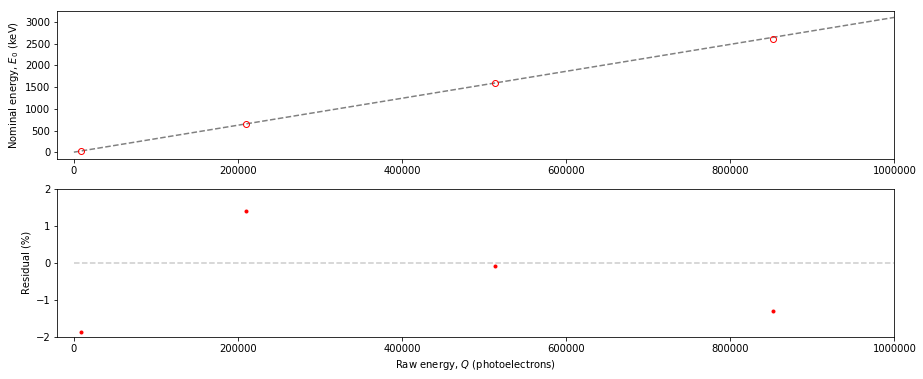

In [81]:
p, V = curve_fit(flinear, mu_uncal, mu_cal, sigma=sigma_cal, absolute_sigma=True)
a = p[0]
b = p[1]
print("Fit parameters are: a = {}, b = {}".format(a, b))

xfit = np.arange(0,1000000,10.) #np.arange(0,mu_uncal[-1]*1.01,10.)
pfit = np.poly1d([a, b])
sigma_E  = np.array([0, 0, 0, 0])

xres = xfit
res = 100*(mu_cal-pfit(mu_uncal))/mu_cal
res_err = 100*sigma_E/mu_cal
print("Residuals (%): {}".format(res))
#print("Residual error: {}".format(res_err))

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1]) 

ax1 = fig.add_subplot(gs[0])
ax1.plot(xfit, pfit(xfit), '--', color='gray')
ax1.plot(mu_uncal, mu_cal, '.', markerfacecolor='none', markersize=12, color='red')
#ax1.errorbar(mu_uncal, mu_cal, xerr=sigma_uncal, markersize=8, color='red', fmt='.')
#ax1.fill_between(xfit, pfit_minus(xfit), pfit_plus(xfit), facecolor='lightgray')
ax1.set_ylabel('Nominal energy, $E_0$ (keV)')
ax1.set_xlim(-20000,1000000)
#ax1.set_ylim(-0.02,1.02)

ax2 = fig.add_subplot(gs[1])
#ax2.fill_between(xres, 100*pfit_resplus(xres)/pfit(xres), 100*pfit_resminus(xres)/pfit(xres), facecolor='lightgray')
#ax2.errorbar(mu_uncal, res, yerr=res_err, capsize=5, fmt='.', markersize=6, color='red')
ax2.plot(mu_uncal, res, '.', markersize=6, color='red')
ax2.hlines(0.0,xmin=0.0,xmax=1500000,linestyle='--',color='gray',alpha=0.4)
ax2.set_xlabel('Raw energy, $Q$ (photoelectrons)')
ax2.set_ylabel('Residual (%)')
ax2.set_xlim(-20000,1000000)
ax2.set_ylim(-2,2)

plt.savefig("{}/CSTH_energy_calibration.{}".format(save_dir,ftype), bbox_inches='tight')

### Quadratic fit

Fit parameters are: a = -1.3768135826402437e-10, b = 0.003178431071354174, c = 0.8730450927434624
Residuals (%): [-0.12483841  0.14936392 -0.13733389  0.14729371]


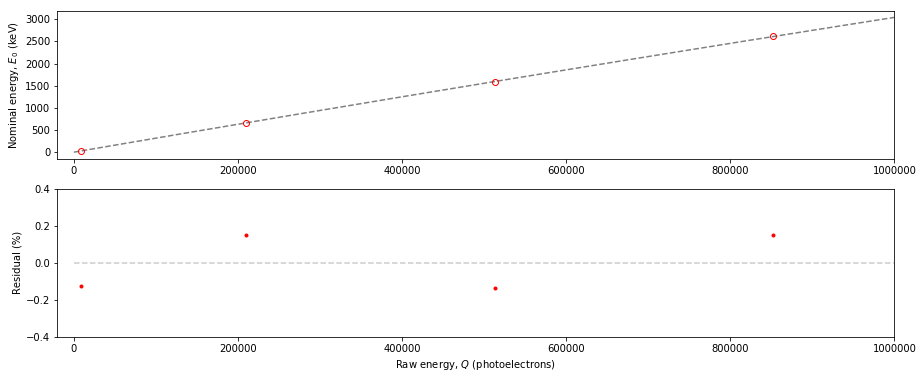

In [82]:
p, V = curve_fit(poly2, mu_uncal, mu_cal, sigma=sigma_cal, absolute_sigma=True)
a = p[0]
b = p[1]
c = p[2]
print("Fit parameters are: a = {}, b = {}, c = {}".format(a, b, c))

xfit = np.arange(0,1000000,10.) #np.arange(0,mu_uncal[-1]*1.01,10.)
pfit = np.poly1d([a, b, c])
sigma_E  = np.array([0, 0, 0, 0])

xres = xfit
res = 100*(mu_cal-pfit(mu_uncal))/mu_cal
res_err = 100*sigma_E/mu_cal
print("Residuals (%): {}".format(res))
#print("Residual error: {}".format(res_err))

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)
gs = gridspec.GridSpec(2, 1, height_ratios=[1,1]) 

ax1 = fig.add_subplot(gs[0])
ax1.plot(xfit, pfit(xfit), '--', color='gray')
ax1.plot(mu_uncal, mu_cal, '.', markerfacecolor='none', markersize=12, color='red')
#ax1.errorbar(mu_uncal, mu_cal, xerr=sigma_uncal, markersize=8, color='red', fmt='.')
#ax1.fill_between(xfit, pfit_minus(xfit), pfit_plus(xfit), facecolor='lightgray')
ax1.set_ylabel('Nominal energy, $E_0$ (keV)')
ax1.set_xlim(-20000,1000000)
#ax1.set_ylim(-0.02,1.02)

ax2 = fig.add_subplot(gs[1])
#ax2.fill_between(xres, 100*pfit_resplus(xres)/pfit(xres), 100*pfit_resminus(xres)/pfit(xres), facecolor='lightgray')
#ax2.errorbar(mu_uncal, res, yerr=res_err, capsize=5, fmt='.', markersize=6, color='red')
ax2.plot(mu_uncal, res, '.', markersize=6, color='red')
ax2.hlines(0.0,xmin=0.0,xmax=1500000,linestyle='--',color='gray',alpha=0.4)
ax2.set_xlabel('Raw energy, $Q$ (photoelectrons)')
ax2.set_ylabel('Residual (%)')
ax2.set_xlim(-20000,1000000)
ax2.set_ylim(-0.4,0.4)

plt.savefig("{}/CSTH_energy_calibration.{}".format(save_dir,ftype), bbox_inches='tight')

----------

## Lifetime plot

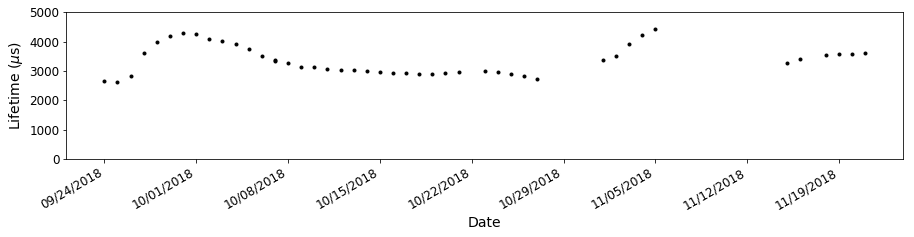

In [152]:
lfdata = pd.read_csv("lt_vs_time_6341_6486.txt",sep=' ')
lf_rnum = lfdata['Run'].values
lf_dates = lfdata['Date'].values
lf_lifetimes = lfdata['Lifetime'].values
lf_dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in lf_dates]

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(15.0)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
plt.gca().xaxis.set_tick_params(labelsize=12)
plt.gca().yaxis.set_tick_params(labelsize=12)
plt.plot(lf_dates,lf_lifetimes,'.',color='black')
plt.gcf().autofmt_xdate()
plt.ylabel("Lifetime ($\mu$s)")
plt.xlabel("Date")
plt.ylim([0,5000])
plt.savefig("{}/CSTH_lifetime.{}".format(save_dir,ftype), bbox_inches='tight')

---

# Misc. plots for reference

## Energy vs. time

In [ ]:
# Energy vs. time
cuts_T = C_wide

nbins = 8

print(A_time[0])
print(A_time[-1])

# for double-escape peak
Thist_min_D = A_time[0] #1531175.7
Thist_max_D = A_time[-1] #1531210.6
Ehist_min_D = 1560
Ehist_max_D = 1650
plt_rng_Tlow_D = A_time[0]
plt_rng_Thigh_D = A_time[-1]
plt_rng_Elow_D = 1400
plt_rng_Ehigh_D = 1800

# for Cs peak
Thist_min_Cs = A_time[0]
Thist_max_Cs = A_time[-1]
Ehist_min_Cs = 648
Ehist_max_Cs = 672
plt_rng_Tlow_Cs = A_time[0]
plt_rng_Thigh_Cs = A_time[-1]
plt_rng_Elow_Cs = 600
plt_rng_Ehigh_Cs = 700

Tprof_D, Eprof_D, Eerr_D = fitf.profileX(A_time[cuts_T],A_Ecplot[cuts_T],nbins=nbins,xrange=(Thist_min_D,Thist_max_D),yrange=(Ehist_min_D,Ehist_max_D))
Tprof_Cs, Eprof_Cs, Eerr_Cs = fitf.profileX(A_time[cuts_T],A_Ecplot[cuts_T],nbins=nbins,xrange=(Thist_min_Cs,Thist_max_Cs),yrange=(Ehist_min_Cs,Ehist_max_Cs))

prof_D  = interp1d(Tprof_D, Eprof_D, fill_value="extrapolate", kind="cubic")
prof_Cs = interp1d(Tprof_Cs, Eprof_Cs, fill_value="extrapolate", kind="cubic")

fig = plt.figure()
fig.patch.set_alpha(0.0)
fig.set_figheight(13.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(221);
ax1.scatter(A_time[cuts_T],A_Ecplot[cuts_T],s=0.5)
ax1.axhline(y=Ehist_min_D,c="red",linewidth=1.2,linestyle='dashed')
ax1.axhline(y=Ehist_max_D,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. T")
plt.ylim([plt_rng_Elow_D,plt_rng_Ehigh_D])
plt.xlim([plt_rng_Tlow_D,plt_rng_Thigh_D])
plt.xlabel('T')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(222);
ax2.errorbar(Tprof_D,Eprof_D,yerr=Eerr_D)
ax2.plot(np.arange(plt_rng_Tlow_D,plt_rng_Thigh_D,0.01),prof_D(np.arange(plt_rng_Tlow_D,plt_rng_Thigh_D,0.01)),'-',color='black',linewidth=3)
plt.title("Energy vs. T profile: E $\in$ ({0},{1})".format(Ehist_min_D,Ehist_max_D))
plt.xlabel('T')
plt.ylabel('E (keV)')

ax5 = fig.add_subplot(223);
ax5.scatter(A_time[cuts_T],A_Ecplot[cuts_T],s=0.5)
ax5.axhline(y=Ehist_min_Cs,c="red",linewidth=1.2,linestyle='dashed')
ax5.axhline(y=Ehist_max_Cs,c="red",linewidth=1.2,linestyle='dashed')
plt.title("Energy vs. T")
plt.ylim([plt_rng_Elow_Cs,plt_rng_Ehigh_Cs])
plt.xlim([plt_rng_Tlow_Cs,plt_rng_Thigh_Cs])
plt.xlabel('T')
plt.ylabel('E (keV)')

ax6 = fig.add_subplot(224);
ax6.errorbar(Tprof_Cs,Eprof_Cs,yerr=Eerr_Cs)
ax6.plot(np.arange(plt_rng_Tlow_Cs,plt_rng_Thigh_Cs,0.01),prof_Cs(np.arange(plt_rng_Tlow_Cs,plt_rng_Thigh_Cs,0.01)),'-',color='black',linewidth=3)
plt.title("Energy vs. T profile: E $\in$ ({0},{1})".format(Ehist_min_Cs,Ehist_max_Cs))
plt.xlabel('T')
plt.ylabel('E (keV)')

plt.savefig("{}/CSTH_E_vs_T.{}".format(save_dir,ftype), bbox_inches='tight')